# Experimental CNN Framework for Landsat Classification

In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools

from classifier_utilities import *

### importing datasets

In [2]:
label_dataset = rasterio.open('/deep_data/NLCD/NLCD_2016_Land_Cover_L48_20190424.img')

l8_image_paths = [
    '/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
    '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined.tif',
    '/deep_data/processed_landsat/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined.tif'
]

s1_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined/aligned-LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined/aligned-LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined/aligned-LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined/aligned-LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_SAR.tif',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined/aligned-LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_SAR.tif',
]

dem_image_paths = [
    '/deep_data/sentinel_sar/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-77.7672_35.00779_-75.79042_36.58923__4500X4262_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-79.69001_33.95762_-77.7672_35.51886__4500X4631_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_028012_20171103_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-78.07896_33.69485_-76.14021_35.27466__4500X4248_ShowLogo_False_tiff_depth=32f.tiff',
    '/deep_data/sentinel_sar/LC08_CU_029011_20171018_20190429_C01_V01_SR_combined_dem/aligned-wms_DEM_EPSG4326_-76.14021_34.71847_-74.14865_36.318__4500X4408_ShowLogo_False_tiff_depth=32f.tiff',
]


landsat_datasets = []
for fp in l8_image_paths:
    landsat_datasets.append(rasterio.open(fp))
    
sentinel_datasets = []
for fp in s1_image_paths:
    sentinel_datasets.append(rasterio.open(fp))
    
dem_datasets = []
for fp in dem_image_paths:
    dem_datasets.append(rasterio.open(fp))



In [3]:
# What is the raster's projection?
image_proj = landsat_datasets[0].crs # 4326
print('Image projection:')
print(image_proj)
print('---')
# What is the raster's projection?
label_proj = sentinel_datasets[0].crs
print('Labels projection:')
print(label_proj)
print('---')
# What is the raster's projection?
label_proj = dem_datasets[0].crs
print('Labels projection:')
print(label_proj)
print('---')
# What is the raster's projection?
label_proj = label_dataset.crs
print('Labels projection:')
print(label_proj)

Image projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
---
Labels projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PAR

### Class Dictionary and Confusion Matrix Function

In [4]:
class_names = dict((
(11, "Water"),
(12, "Snow/Ice"),
(21, "Open Space Developed"),
(22, "Low Intensity Developed"),
(23, "Medium Intensity Developed"),
(24, "High Intensity Developed"),
(31, "Barren Land"),
(41, "Deciduous Forest"),
(42, "Evergreen Forest"),
(43, "Mixed Forest"),
#(51, "Dwarf Scrub/Shrub - ALASKA"),
(52, "Scrub/Shrub"),
(71, "Grassland / Herbaceous"),
#(72, "Sedge / Herbaceous - ALASKA"),
#(73, "Lichen / Herbaceous - ALASKA"),
#(74, "Moss - ALASKA"),
(81, "Pasture/Hay"),
(82, "Cultivated Land"),
(90, "Woody Wetland"),
(95, "Emergent Herbaceous Wetlands"),
))

## Test out the generator and data prep functions

Let's make sure all this data prep actually works.

In [5]:
all_random_px = gen_pixel_locations(landsat_datasets, 100000, 0, 11)

KeyboardInterrupt: 

In [ ]:
len(all_random_px[0])

In [7]:
eval_generator = tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, 
                                label_dataset, 11, 11, all_random_px[0], batch_size=100000)

image_b, label_b = next(eval_generator)

In [8]:
image_b.shape

(100000, 11, 11, 10)

In [9]:
image_b[:,:,:,0:7].mean()

982.4954514521842

In [10]:
image_b[:,:,:,0:7].std()

1076.4081358422638

In [17]:
((image_b[:,:,:,0:7] - 982.5) / 1076.5).std()

0.9999146640429726

In [19]:
image_b[:,:,:,7:9].mean()

0.09912027174750683

In [20]:
image_b[:,:,:,7:9].std()

0.08702391609189894

In [25]:
((image_b[:,:,:,7:9] - 0.10) / 0.088).std()

0.988908137407942

In [26]:
image_b[:,:,:,9].mean()

31.870819596108273

In [27]:
image_b[:,:,:,9].std()

16.449048098707472

In [105]:
np.median(image_b[:,:,:,9])

30.96021270751953

In [29]:
((image_b[50000:50200,:,:,9] - 31) / 16.5).std()

1.1131584759160476

In [ ]:
train_pixels = gen_balanced_pixel_locations(image_datasets=landsat_datasets, train_count=50000, 
                                            label_dataset=label_dataset, merge=False)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# generate the training and validation pixel locations
all_labels = []
label_locations = []
for pixel in train_pixels:
    # row, col location in landsat
    r,c = pixel[0]
    ds_index = pixel[1]
    ds_index = 4
    l8_proj = Proj(landsat_datasets[ds_index].crs)
    label_proj = Proj(label_dataset.crs)
    
    # geographic location in landsat
    x,y = landsat_datasets[ds_index].xy(r,c)
    # go from label projection into landsat projection
    x,y = transform(l8_proj, label_proj ,x,y)
    # get row and col location in label
    r,c = label_dataset.index(x,y)
    
    label_locations.append([r,c])
    
    # format (bands, height, width)
    window = ((r, r+1), (c, c+1))
    data = label_dataset.read(1, window=window, masked=False, boundless=True)
    all_labels.append(data[0,0])
    
label_locations = np.array(label_locations)

unique, counts = np.unique(np.array(all_labels), return_counts=True)
dict(zip(unique, counts))

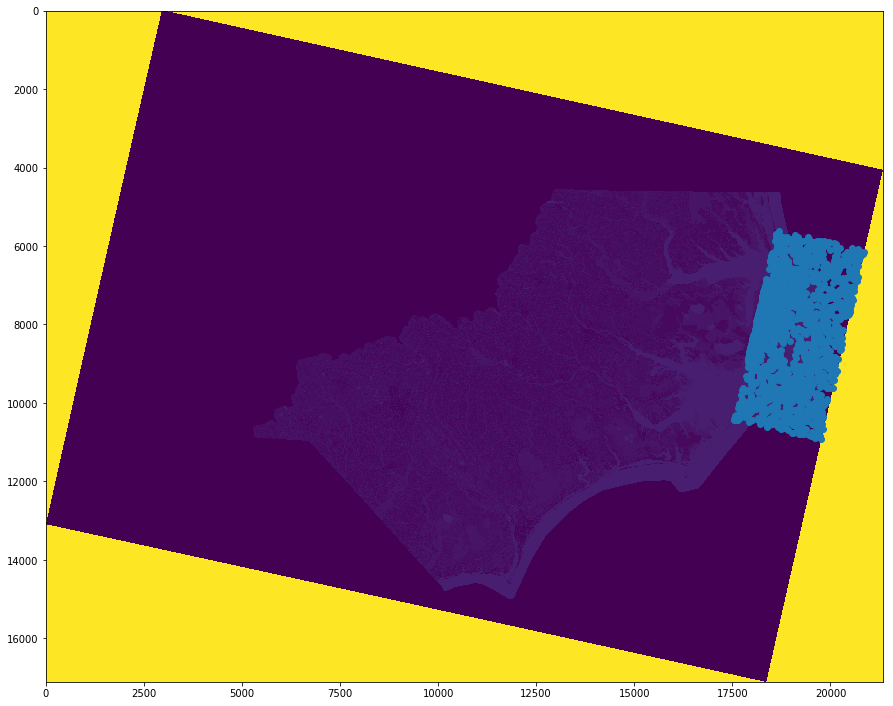

In [7]:
fig, ax = plt.subplots(figsize=[15,15])
ax.imshow(label_image[0,:,:])

plt.scatter(label_locations[:10000, 1], label_locations[:10000, 0])

In [8]:
# print out some image and label batches and check out their shapes
im_batch = None

count = 0
for (im, label) in tile_generator(landsat_datasets[4:], sentinel_datasets[4:], dem_datasets[4:], label_dataset, 128, 128, train_pixels, 10):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    #print('Label')
    #print(label)
    #print(label.shape)
    print('----')
    count += 1
    im_batch = im

Image
(10, 128, 128, 10)
----
Image
(10, 128, 128, 10)
----
Image
(10, 128, 128, 10)
----
Image
(10, 128, 128, 10)
----


### Visually inspect an image patch

While it shouldn't necessarily be recognizable it should look like it has data in it and that it varies somewhat from pixel to pixel.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


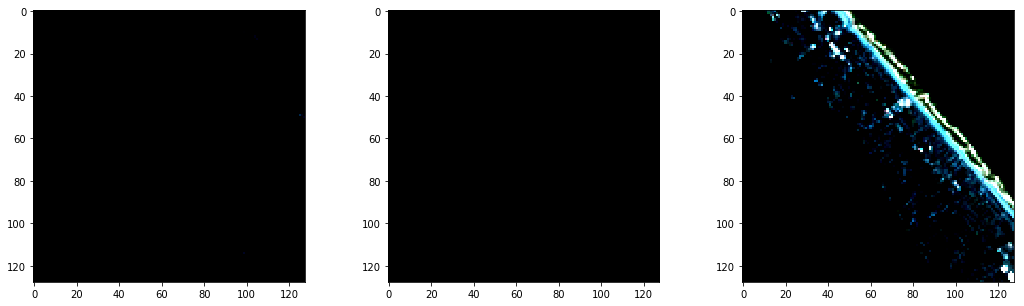

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5)) 

axs[0].imshow(im_batch[0,:,:,1:4])
axs[1].imshow(im_batch[1,:,:,1:4])
axs[2].imshow(im_batch[2,:,:,1:4])

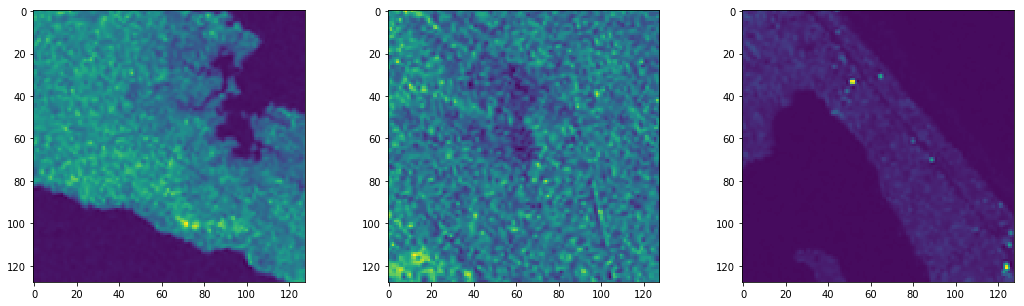

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5)) 
axs[0].imshow(im_batch[0,:,:,8])
axs[1].imshow(im_batch[1,:,:,8])
axs[2].imshow(im_batch[2,:,:,8])

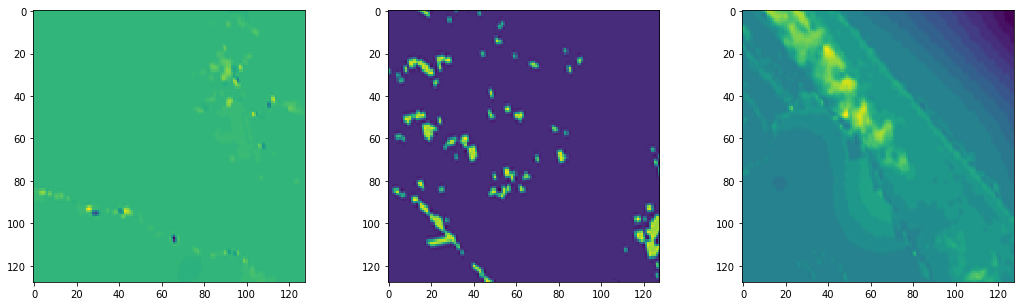

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5)) 
axs[0].imshow(im_batch[0,:,:,9])
axs[1].imshow(im_batch[1,:,:,9])
axs[2].imshow(im_batch[2,:,:,9])

## Let's get to the CNN Development!!

In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use
# Patrick "0"
# Feroze  "1"
# Yousuf  "2"
# Diego   "3"
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [12]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use
# Patrick "0"
# Feroze  "1"
# Yousuf  "2"
# Diego   "3"
os.environ["CUDA_VISIBLE_DEVICES"]="2";

In [13]:
# Do other imports now...
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint


K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

### prep some of the hyperparameters

In [28]:
batch_size = 25
epochs = 200
num_classes = len(class_names)

# input image dimensions
tile_side = 64
img_rows, img_cols = tile_side, tile_side
img_bands = landsat_datasets[0].count + sentinel_datasets[0].count + dem_datasets[0].count - 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(64, 64, 10)


### build the model

This is just a simple CNN model but it should be able to perform well above random when predicting landcover types if everything is correct thus far.

In [29]:
model = Sequential()

model.add(Conv2D(32, (1, 1), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# model.add(Conv2D(64, (1, 1), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 32)        352       
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_17 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_17 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
activation_18 (Activation)   (None, 64, 64, 64)        0         
__________

In [32]:
model = Sequential()

model.add(Conv2D(tile_side, kernel_size=(3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 30, 30, 32)        2912      
_________________________________________________________________
batch_normalization_44 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
activation_47 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_45 (Batc (None, 13, 13, 64)        256       
__________

In [27]:
model = Sequential()

model.add(Conv2D(tile_side, kernel_size=(3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        2912      
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_10 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
activation_11 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
__________

#### Future Models for Experimentation

In [24]:
from keras import regularizers
from keras.layers import Activation, BatchNormalization

weight_decay=1e-6

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 32)        2624      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
__________

#### Generate the train/validation pixel locations to train with

In [30]:
train_to_val_ratio = 0.7
train_px = train_pixels[:int(len(train_pixels)*train_to_val_ratio)]
val_px = train_pixels[int(len(train_pixels)*train_to_val_ratio):]

In [31]:
len(train_px)

28720

In [32]:
len(val_px)

12309

#### set up the remaining model hyperparameters and compile

In [34]:
sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
metrics=['accuracy']

# load weights
#model.load_weights("weights.best.hdf5")

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)

In [35]:
# checkpoint
#filepath="model_weights/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
filepath="model_weights/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#### TRAIN THE MODEL!

In [36]:
history = model.fit_generator(generator=tile_generator(landsat_datasets[4:], sentinel_datasets[4:], dem_datasets[4:], label_dataset, tile_side, tile_side, train_px, batch_size, merge=False), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=100, verbose=1,
                    validation_data=tile_generator(landsat_datasets[4:], sentinel_datasets[4:], dem_datasets[4:], label_dataset, tile_side, tile_side, val_px, batch_size, merge=False),
                    validation_steps=len(val_px) // batch_size,
                    callbacks=callbacks_list)

Epoch 1/100
1148/1148 [==============================] - 125s 109ms/step - loss: 2.2914 - acc: 0.3042 - val_loss: 3.3839 - val_acc: 0.1971

Epoch 00001: val_acc improved from -inf to 0.19707, saving model to model_weights/weights.best.hdf5
Epoch 2/100
1148/1148 [==============================] - 121s 105ms/step - loss: 1.7881 - acc: 0.4185 - val_loss: 3.4750 - val_acc: 0.2155

Epoch 00002: val_acc improved from 0.19707 to 0.21553, saving model to model_weights/weights.best.hdf5
Epoch 3/100
1148/1148 [==============================] - 121s 105ms/step - loss: 1.6545 - acc: 0.4492 - val_loss: 2.8232 - val_acc: 0.2719

Epoch 00003: val_acc improved from 0.21553 to 0.27187, saving model to model_weights/weights.best.hdf5
Epoch 4/100
1148/1148 [==============================] - 121s 105ms/step - loss: 1.5846 - acc: 0.4766 - val_loss: 2.7997 - val_acc: 0.2689

Epoch 00004: val_acc did not improve from 0.27187
Epoch 5/100
1148/1148 [==============================] - 120s 105ms/step - loss: 1.5

Epoch 39/100
1148/1148 [==============================] - 123s 107ms/step - loss: 0.8992 - acc: 0.6842 - val_loss: 1.2271 - val_acc: 0.6052

Epoch 00039: val_acc did not improve from 0.61902
Epoch 40/100
1148/1148 [==============================] - 122s 107ms/step - loss: 0.8906 - acc: 0.6876 - val_loss: 1.2053 - val_acc: 0.6120

Epoch 00040: val_acc did not improve from 0.61902
Epoch 41/100
1148/1148 [==============================] - 123s 107ms/step - loss: 0.8700 - acc: 0.6918 - val_loss: 1.1971 - val_acc: 0.6227

Epoch 00041: val_acc improved from 0.61902 to 0.62268, saving model to model_weights/weights.best.hdf5
Epoch 42/100
1148/1148 [==============================] - 122s 107ms/step - loss: 0.8481 - acc: 0.6997 - val_loss: 1.2162 - val_acc: 0.6176

Epoch 00042: val_acc did not improve from 0.62268
Epoch 43/100
1148/1148 [==============================] - 122s 107ms/step - loss: 0.8439 - acc: 0.7024 - val_loss: 1.2354 - val_acc: 0.6069

Epoch 00043: val_acc did not improve from 

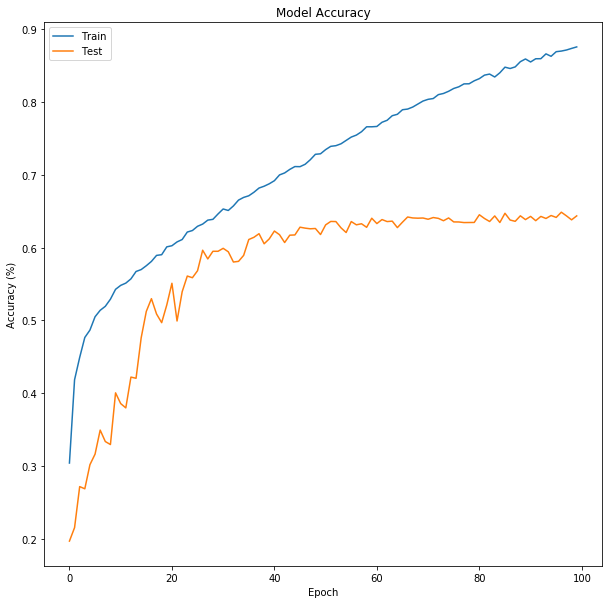

In [37]:
plt.figure(figsize=(10,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

### Now let's evaluate the Model

We'll just generate 500 test pixels to evaluate it on

Keras has a built in evaluate_generator function and because we told it above to use accuracy as a metric this function automatically outputs categorical accuracy which is what we want.

In [38]:
model.evaluate_generator(generator=tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, label_dataset, tile_side, tile_side, val_px, batch_size), 
                        steps=len(val_px) // batch_size,
                         verbose=1)

492/492 [==============================] - 50s 101ms/step


[9.01376233159042, 0.4045528445726003]

So in this simple model we're getting 37% accuracy across 23 classes which is well above the random accuracy which would be around 4% (aka 1/23). That means we're in business!

### Evaluating the model ourselves

If we wanted to run this evaluation and take a look at specific predictions and labels we can do that below (albeit more inefficiently) just to get an intuitive understanding of what is going wrong.

Now maybe more informatively let's build a confusion matrix using the scikit-learn function.

Read the docs here and make this more informative by following some of their examples: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

492/492 [==============================] - 23s 47ms/step


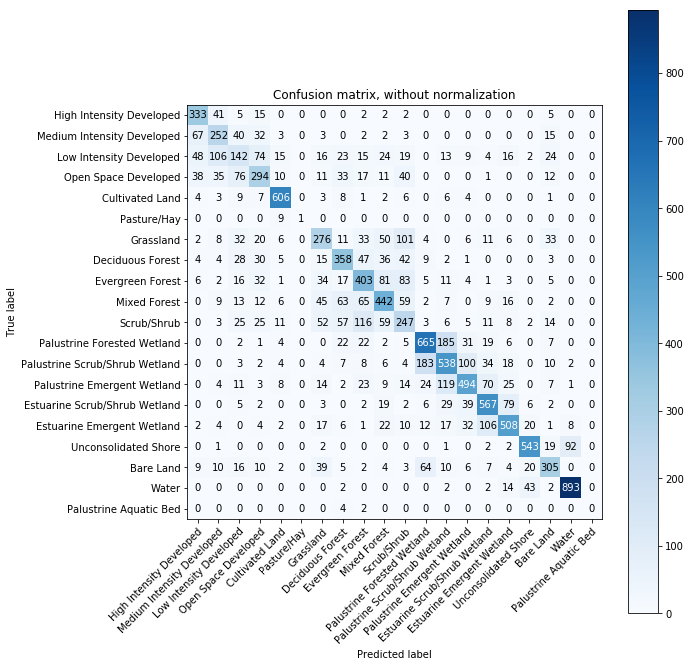

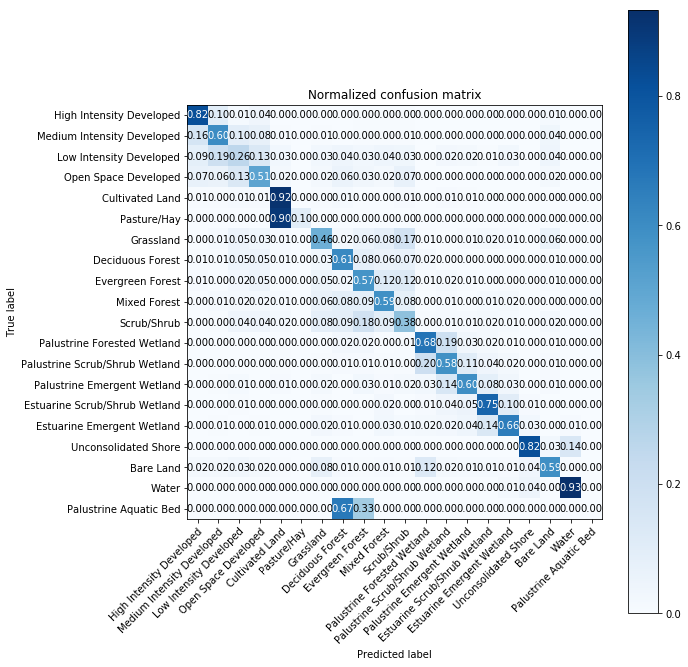

In [39]:
predictions = model.predict_generator(generator=tile_generator(landsat_datasets[4:], sentinel_datasets[4:], dem_datasets[4:], 
        label_dataset, tile_side, tile_side, val_px, batch_size, merge=False), 
                        steps=len(val_px) // batch_size,
                         verbose=1)

eval_generator = tile_generator(landsat_datasets[4:], sentinel_datasets[4:], dem_datasets[4:], 
                                label_dataset, tile_side, tile_side, val_px, batch_size=1, merge=False)

labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1
    
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

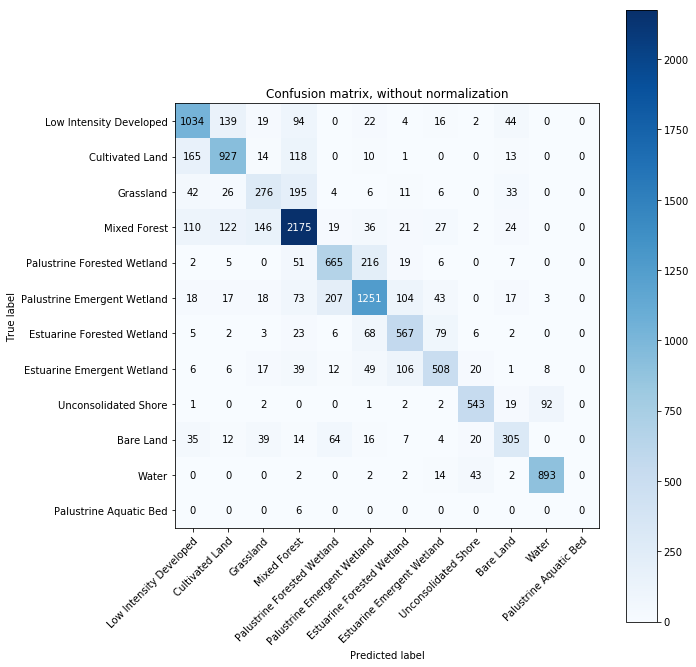

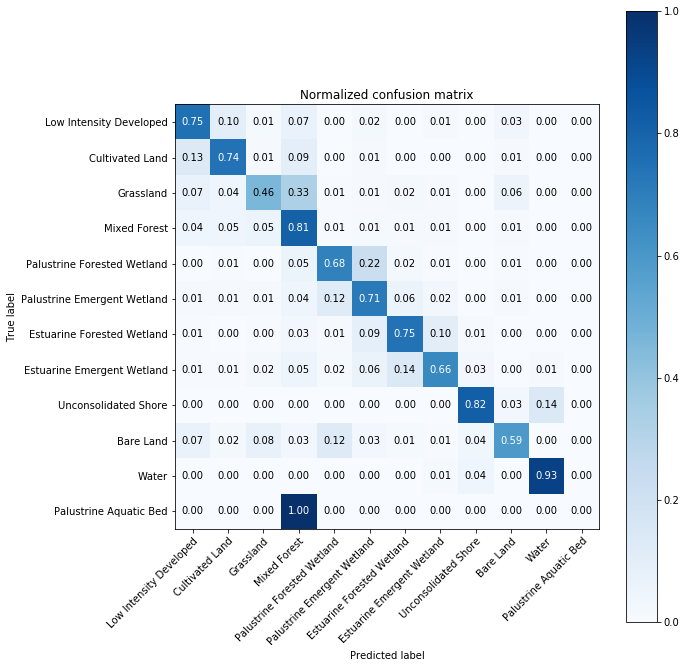

In [40]:
pred_index = merge_classes_extra(pred_index)
label_index = merge_classes_extra(label_index)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [23]:
def merge_classes_extra(y):
    # medium intensity and high intensity
    y[y == 3] = 2
    # open space developed, cultivated land, and pasture hay
    y[y == 5] = 6
    y[y == 7] = 6
    # decidious and mixed
    y[y == 9] = 11
    # evergreen and scrub shrub
    y[y == 12] = 10
    # pal wetland and pal scrub shrub
    y[y == 14] = 15
    # est forest and est scrub shrub
    y[y == 17] = 16
    
    ###
    # merge developed
    y[y == 2] = 4
    # merge evergreen and mixed forest
    y[y == 10] = 11
    
    return(y)

In [ ]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

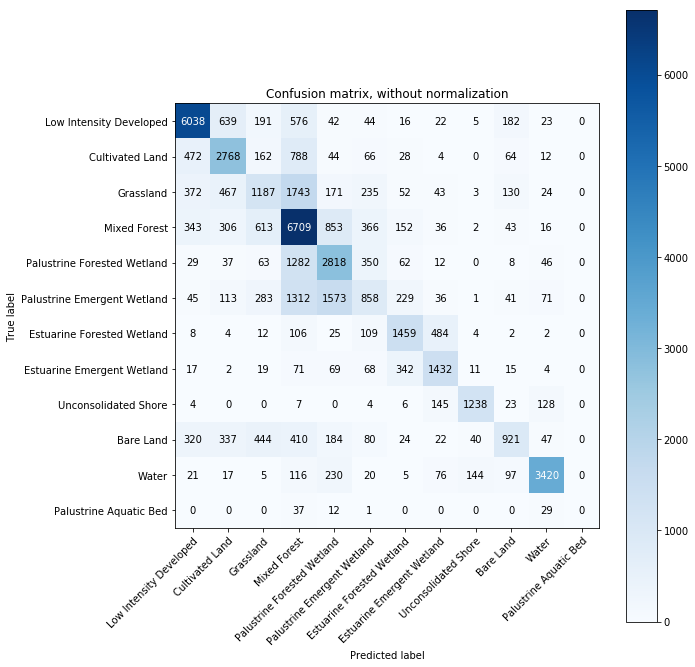

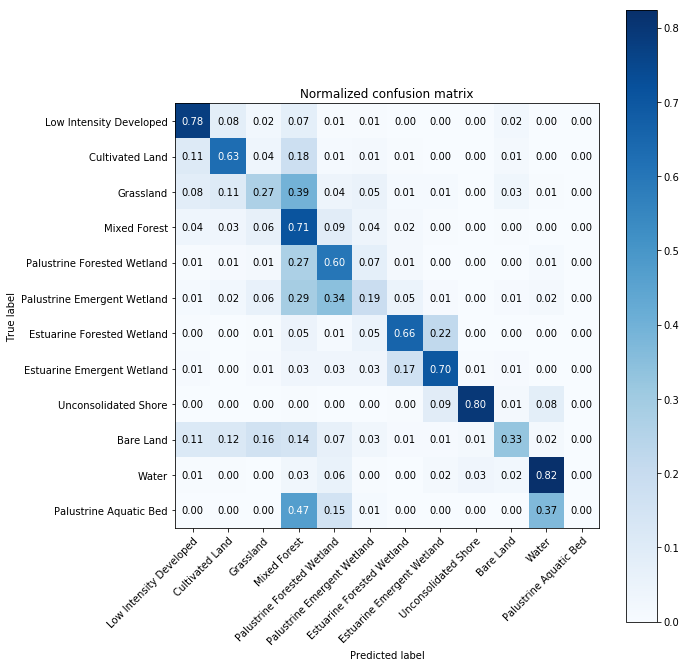

In [73]:
    
label_index_merge = merge_classes_extra(label_index)
pred_index_merge = merge_classes_extra(pred_index)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index_merge, pred_index_merge, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index_merge, pred_index_merge, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

869/869 [==============================] - 47s 55ms/step


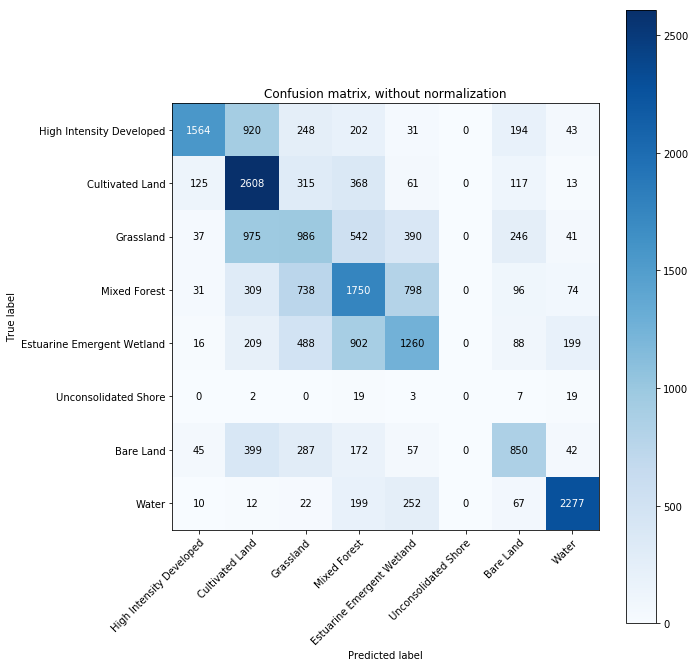

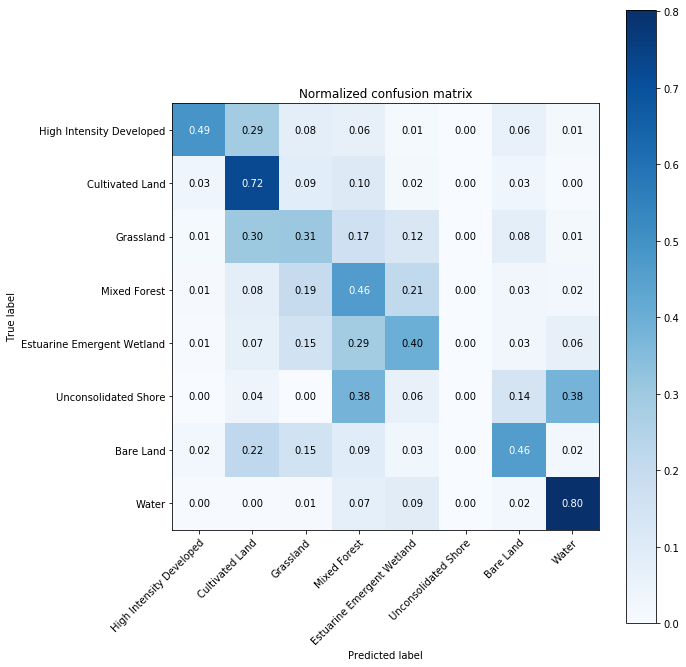

In [36]:
predictions = model.predict_generator(generator=tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, 
        label_dataset, tile_side, tile_side, val_px, batch_size), 
                        steps=len(val_px) // batch_size,
                         verbose=1)

eval_generator = tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, 
                                label_dataset, tile_side, tile_side, val_px, batch_size=1)

labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1
    
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [37]:
unique, counts = np.unique(label_index, return_counts=True)
dict(zip(unique, counts))

{2: 3202, 6: 3607, 8: 3217, 11: 3796, 18: 3162, 19: 50, 20: 1852, 21: 2839}

In [38]:
unique, counts = np.unique(pred_index, return_counts=True)
dict(zip(unique, counts))

{2: 1828, 6: 5434, 8: 3084, 11: 4154, 18: 2852, 20: 1665, 21: 2708}

### Produce a Map

In [ ]:
ingest a full map of pixels, I guess just give the model a set of tiles where every location is there
run through each pixel and assign a value to a new numpy array

In [40]:
xs = np.arange(0,5000)
ys = np.arange(0,5000)
full_img_pixels = list(itertools.product(xs, ys))

dataset_index_list = [0] * len(full_img_pixels)

full_img_pixels = list(zip(full_img_pixels, dataset_index_list))

In [41]:
predictions = model.predict_generator(generator=tile_generator(landsat_datasets, sentinel_datasets, dem_datasets, 
        label_dataset, tile_side, tile_side, full_img_pixels, batch_size), 
                        steps=len(full_img_pixels) // batch_size,
                         verbose=1)

  17237/1000000 [..............................] - ETA: 11:35:47

KeyboardInterrupt: 